# Use Case

Many documents contain a mixture of content types: 

* `Semi-structured data`: text and tables
* `Image`: images contain valuable information 

Here, we show how `Unstructured` can be used to partition all 3 types from documents. 

We generate summaries of each content type, using an open source multi-modal model (LLaVA) for image summaries.

We embed summaries and store them w/ the raw table and text chunks. 

For images, we embed and store the summaries only; future work could store the images for final answer generation.

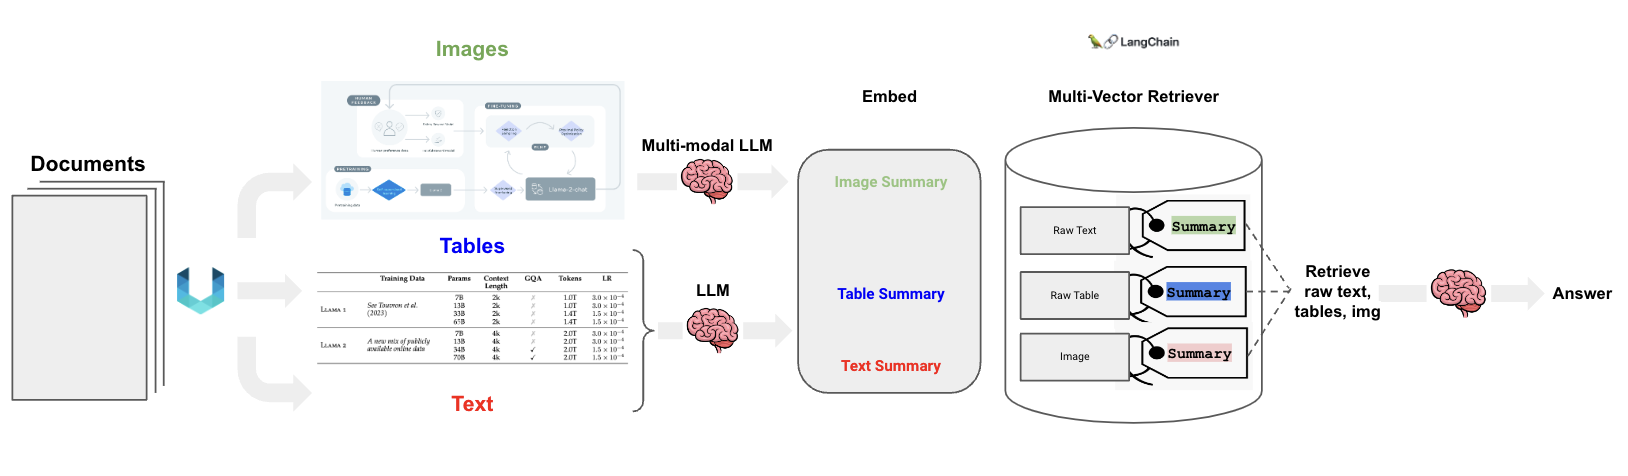

## Data Loading

### Partition PDF tables, text, and images
  
* `LLaVA` Paper: https://arxiv.org/pdf/2304.08485.pdf
* Use `Unstructured` to partition elements

In [1]:
path = "/Users/rlm/Desktop/Papers/LLaVA/"

In [ ]:
import pandas as pd
from lxml import html
from pydantic import BaseModel
from typing import Any, Optional
from unstructured.partition.pdf import partition_pdf

# Get elements
raw_pdf_elements = partition_pdf(filename=path+"LLaVA.pdf",
                                 # Using pdf format to find embedded image blocks
                                 extract_images_in_pdf=True,
                                 # Use layout model (YOLO-X) to get bounding boxes (for tables) and find titles
                                 # Titles are any sub-section of the document 
                                 infer_table_structure=True, 
                                 # Post processing to aggregate text once we have the title 
                                 chunking_strategy="by_title",
                                 # Chunking params to aggregate text blocks
                                 # Attempt to create a new chunk 3800 chars
                                 # Attempt to keep chunks > 2000 chars 
                                 # Hard max on chunks
                                 max_characters=4000, 
                                 new_after_n_chars=3800, 
                                 combine_text_under_n_chars=2000,
                                 image_output_dir_path=path)

In [3]:
# Create a dictionary to store counts of each type
category_counts = {}

for element in raw_pdf_elements:
    category = str(type(element))
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# Unique_categories will have unique elements
unique_categories = set(category_counts.keys())
category_counts

{"<class 'unstructured.documents.elements.CompositeElement'>": 31,
 "<class 'unstructured.documents.elements.Table'>": 3}

In [4]:
class Element(BaseModel):
    type: str
    text: Any

# Categorize by type
categorized_elements = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        categorized_elements.append(Element(type="table", text=str(element)))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        categorized_elements.append(Element(type="text", text=str(element)))

# Tables
table_elements = [e for e in categorized_elements if e.type == "table"]
print(len(table_elements))

# Text
text_elements = [e for e in categorized_elements if e.type == "text"]
print(len(text_elements))

3
31


## Multi-vector retriever

Use [multi-vector-retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary).

Summaries are used to retrieve raw tables and / or raw chunks of text.

### Text and Table summaries

In [6]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

In [7]:
# Prompt 
prompt_text="""You are an assistant tasked with summarizing tables and text. \ 
Give a concise summary of the table or text. Table or text chunk: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text) 

# Summary chain 
model = ChatOpenAI(temperature=0,model="gpt-4")
summarize_chain = {"element": lambda x:x} | prompt | model | StrOutputParser()

In [8]:
# Apply to text
texts = [i.text for i in text_elements]
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})

In [ ]:
# Apply to tables
tables = [i.text for i in table_elements]
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

### Images

There are at least three ways to add images to the RAG stack.

`(1) Produce text summaries of images with a multi-modal LLM.`

* 1. Embed, store, and retrieve text summaries like any other text chunk.

`(2) Retrieve images.`

* 2a. Text-embeddings: Produce text summaries of images, embed them, and use them to fetch the raw image in retrieval. 
* 2b. Multi-modal embeddings: Directly embed images along with text.

Below we show 1, but future extensions will show the other paths. 

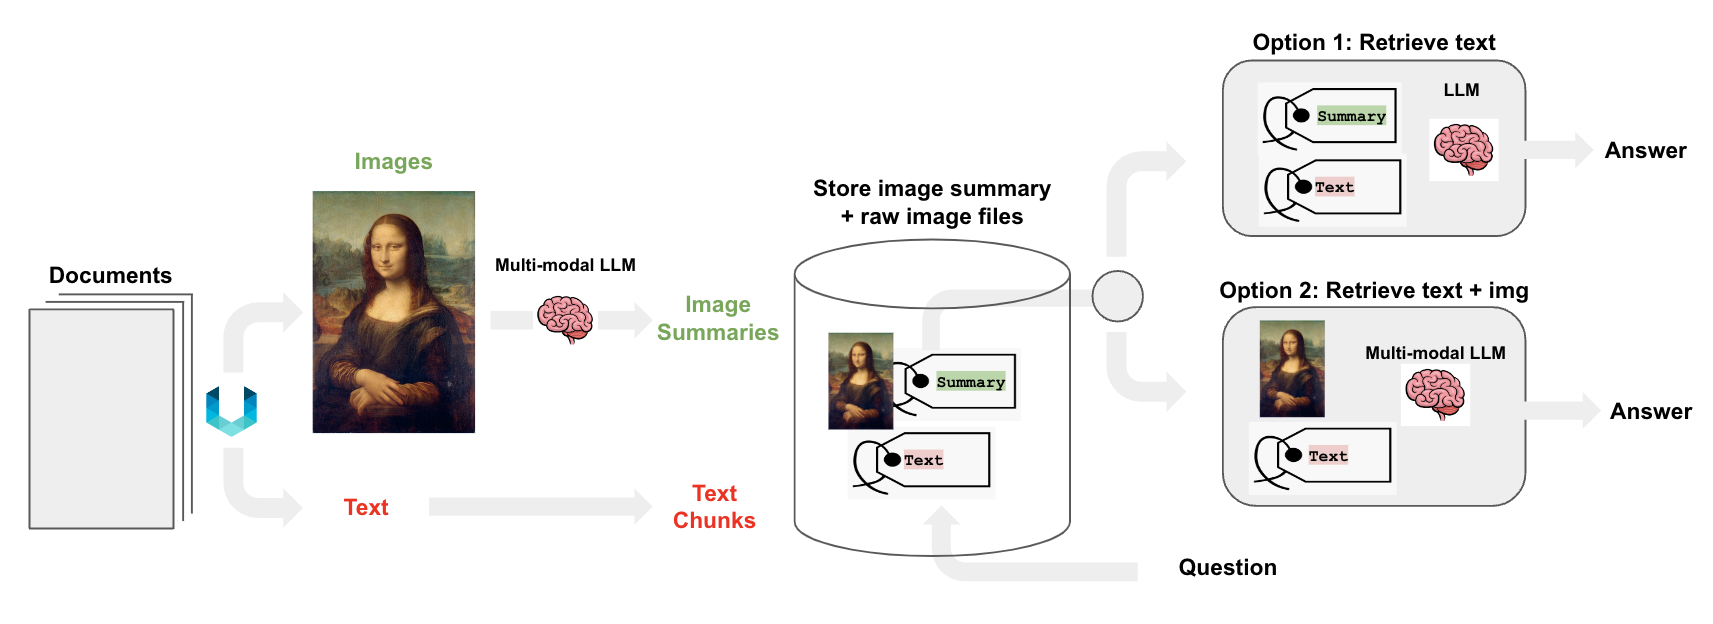

#### Image summaries 

We will use [LLaVA](https://github.com/haotian-liu/LLaVA/), an open source multi-modal model.
 
We will use [llama.cpp](https://github.com/ggerganov/llama.cpp/pull/3436) to run LLaVA locally (e.g., on a Mac laptop):

* Clone [llama.cpp](https://github.com/ggerganov/llama.cpp)
* Download the LLaVA model: `mmproj-model-f16.gguf` and one of `ggml-model-[f16|q5_k|q4_k].gguf` from [LLaVA 7b repo](https://huggingface.co/mys/ggml_llava-v1.5-7b/tree/main)
* Build
```
mkdir build && cd build && cmake ..
cmake --build .
```
* Run inference
```
/Users/rlm/Desktop/Code/llama.cpp/bin/llava -m ../models/llava-7b/ggml-model-q5_k.gguf --mmproj ../models/llava-7b/mmproj-model-f16.gguf --temp 0.1 -p "Describe the image in detail. Be specific about graphs, such as bar plots." --image "$img" > "$output_file"
```

For [better performance](https://github.com/ggerganov/llama.cpp/issues/3602):

* It appears `7b` is currently better than `13b` in the [LLaVA repo](https://huggingface.co/mys/ggml_llava-v1.5-7b/tree/main)
* Use `--temp 0.1`

In [ ]:
%%bash

# Define the directory containing the images
IMG_DIR=~/Desktop/Papers/LLaVA/

# Loop through each image in the directory
for img in "${IMG_DIR}"*.jpg; do
    # Extract the base name of the image without extension
    base_name=$(basename "$img" .jpg)

    # Define the output file name based on the image name
    output_file="${IMG_DIR}${base_name}.txt"

    # Execute the command and save the output to the defined output file
    /Users/rlm/Desktop/Code/llama.cpp/bin/llava -m ../models/llava-7b/ggml-model-q5_k.gguf --mmproj ../models/llava-7b/mmproj-model-f16.gguf --temp 0.1 -p "Describe the image in detail. Be specific about graphs, such as bar plots." --image "$img" > "$output_file"

done

In [ ]:
%%bash

# Define the directory containing the images
IMG_DIR=~/Desktop/Papers/LLaVA/

# Loop through each image in the directory
for img in "${IMG_DIR}"*.jpg; do
    # Extract the base name of the image without extension
    base_name=$(basename "$img" .jpg)

    # Define the output file name based on the image name
    output_file="${IMG_DIR}${base_name}.txt"

    # Execute the command and save the output to the defined output file
    /Users/rlm/Desktop/Code/llama.cpp/bin/llava -m ../models/llava-7b/ggml-model-q5_k.gguf --mmproj ../models/llava-7b/mmproj-model-f16.gguf --temp 0.1 -p "Describe the image in detail. Be specific about graphs, such as bar plots." --image "$img" > "$output_file"

done

In [25]:
import os, glob

# Get all .txt file summaries
file_paths = glob.glob(os.path.expanduser(os.path.join(path, "*.txt")))

# Read each file and store its content in a list
img_summaries = []
for file_path in file_paths:
    with open(file_path, 'r') as file:
        img_summaries.append(file.read())

# Remove any logging prior to summary
logging_header="clip_model_load: total allocated memory: 201.27 MB\n\n"
cleaned_img_summary = [s.split(logging_header, 1)[1].strip() for s in img_summaries]

Fetch / clean image summaries.

In [12]:
import os, glob

# Get all .txt files in the directory
file_paths = glob.glob(os.path.expanduser(os.path.join(path, "*.txt")))

# Read each file and store its content in a list
img_summaries = []
for file_path in file_paths:
    with open(file_path, 'r') as file:
        img_summaries.append(file.read())

# Clean up residual logging
cleaned_img_summary = [s.split("clip_model_load: total allocated memory: 201.27 MB\n\n", 1)[1].strip() for s in img_summaries]

### Add to vectorstore

Use [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary) with summaries.

In [10]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(
    collection_name="summaries",
    embedding_function=OpenAIEmbeddings()
)

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore, 
    docstore=store, 
    id_key=id_key,
)

# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [Document(page_content=s,metadata={id_key: doc_ids[i]}) for i, s in enumerate(text_summaries)]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [Document(page_content=s,metadata={id_key: table_ids[i]}) for i, s in enumerate(table_summaries)]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

For `option 1` (above): 

* Store the image summary in the `docstore`, which we return to the LLM for answer generation.

In [13]:
# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in cleaned_img_summary]
summary_img = [Document(page_content=s,metadata={id_key: img_ids[i]}) for i, s in enumerate(cleaned_img_summary)]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, cleaned_img_summary))) 

For `option 2a` (above): 

* Store the images in the `docstore`.

In [ ]:
# Add images
img_ids = [str(uuid.uuid4()) for _ in cleaned_img_summary]
summary_img = [Document(page_content=s,metadata={id_key: img_ids[i]}) for i, s in enumerate(cleaned_img_summary)]
retriever.vectorstore.add_documents(summary_img)
### Fetch images
retriever.docstore.mset(list(zip(img_ids, ### image ### ))) 

### Sanity Check retrieval

The most complex table in the paper:

In [34]:
tables[2]

'Subject Context Modality Grade Method NAT SOC LAN | TXT IMG NO | Gi6~ G7-12 | Average Representative & SoTA methods with numbers reported in the literature Human [30] 90.23 84.97 87.48 | 89.60 87.50 88.10 | 91.59 82.42 88.40 GPT-3.5 [30] 74.64 69.74 76.00 | 74.44 67.28 77.42 | 76.80 68.89 73.97 GPT-3.5 w/ CoT [30] 75.44 70.87 78.09 | 74.68 67.43 79.93 | 78.23 69.68 75.17 LLaMA-Adapter [55] 84.37 88.30 84.36 | 83.72 80.32 86.90 | 85.83 84.05 85.19 MM-CoT gase [57] 87.52 77.17 85.82 | 87.88 82.90 86.83 | 84.65 85.37 84.91 MM-CoT farge [57] 95.91 82.00 90.82 | 95.26 88.80 92.89 | 92.44 90.31 | 91.68 Results with our own experiment runs GPT-4 84.06 73.45 87.36 | 81.87 70.75 90.73 | 84.69 79.10 82.69 LLaVA 90.36 95.95 88.00 | 89.49 88.00 90.66 | 90.93 90.90 90.92 LLaVA+GPT-4 (complement) 90.36 95.50 88.55 | 89.05 87.80 91.08 | 92.22 88.73 90.97 LLaVA+GPT-4 (judge) 91.56 96.74 91.09 | 90.62 88.99 93.52 | 92.73 92.16 92.53'

Here is the summary, which is embedded:

In [35]:
table_summaries[2]

'The table presents the performance of various methods in different subject contexts and modalities. The subjects are Natural Sciences (NAT), Social Sciences (SOC), and Language (LAN). The modalities are text (TXT), image (IMG), and no modality (NO). The methods include Human, GPT-3.5, GPT-3.5 with CoT, LLaMA-Adapter, MM-CoT gase, MM-CoT farge, GPT-4, LLaVA, LLaVA+GPT-4 (complement), and LLaVA+GPT-4 (judge). The performance is measured in grades from 6 to 12. The MM-CoT farge method had the highest performance in most categories, with LLaVA+GPT-4 (judge) showing the highest results in the experiment runs.'

Here is our retrieval of that table from the natural langugae query:

In [38]:
# We can retrive this table
retriever.get_relevant_documents("What are results for LLaMA across across domains / subjects?")[1]

'Subject Context Modality Grade Method NAT SOC LAN | TXT IMG NO | Gi6~ G7-12 | Average Representative & SoTA methods with numbers reported in the literature Human [30] 90.23 84.97 87.48 | 89.60 87.50 88.10 | 91.59 82.42 88.40 GPT-3.5 [30] 74.64 69.74 76.00 | 74.44 67.28 77.42 | 76.80 68.89 73.97 GPT-3.5 w/ CoT [30] 75.44 70.87 78.09 | 74.68 67.43 79.93 | 78.23 69.68 75.17 LLaMA-Adapter [55] 84.37 88.30 84.36 | 83.72 80.32 86.90 | 85.83 84.05 85.19 MM-CoT gase [57] 87.52 77.17 85.82 | 87.88 82.90 86.83 | 84.65 85.37 84.91 MM-CoT farge [57] 95.91 82.00 90.82 | 95.26 88.80 92.89 | 92.44 90.31 | 91.68 Results with our own experiment runs GPT-4 84.06 73.45 87.36 | 81.87 70.75 90.73 | 84.69 79.10 82.69 LLaVA 90.36 95.95 88.00 | 89.49 88.00 90.66 | 90.93 90.90 90.92 LLaVA+GPT-4 (complement) 90.36 95.50 88.55 | 89.05 87.80 91.08 | 92.22 88.73 90.97 LLaVA+GPT-4 (judge) 91.56 96.74 91.09 | 90.62 88.99 93.52 | 92.73 92.16 92.53'

Image:

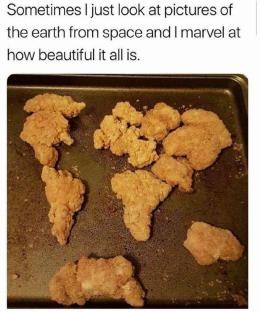

We can retrieve this image summary:

In [41]:
retriever.get_relevant_documents("Images / figures with playful and creative examples")[1]

'The image features a close-up of a tray filled with various pieces of fried chicken. The chicken pieces are arranged in a way that resembles a map of the world, with some pieces placed in the shape of continents and others as countries. The arrangement of the chicken pieces creates a visually appealing and playful representation of the world, making it an interesting and creative presentation.\n\nmain: image encoded in   865.20 ms by CLIP (    1.50 ms per image patch)'

## RAG

Run [RAG pipeline](https://python.langchain.com/docs/expression_language/cookbook/retrieval).

For `option 1` (above): 

* Simply pass retrieved text chunks to LLM, as usual.

For `option 2a` (above): 

* We would pass retrieved image and images to the multi-modal LLM.
* This should be possible soon, once [llama-cpp-python add multi-modal support](https://github.com/abetlen/llama-cpp-python/issues/813).
* And, of course, this will be enabled by GPT4-V API.

In [42]:
from operator import itemgetter
from langchain.schema.runnable import RunnablePassthrough

# Prompt template
template = """Answer the question based only on the following context, which can include text and tables:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# Option 1: LLM
model = ChatOpenAI(temperature=0,model="gpt-4")
# Option 2: Multi-modal LLM
# model = GPT4-V or LLaVA

# RAG pipeline
chain = (
    {"context": retriever, "question": RunnablePassthrough()} 
    | prompt 
    | model 
    | StrOutputParser()
)

In [43]:
chain.invoke("What is the performance of LLaVa across across mutiple image domains / subjects?")

'The performance of LLaMA across multiple image domains/subjects is as follows: In the Natural Science (NAT) subject, it scored 84.37. In the Social Science (SOC) subject, it scored 88.30. In the Language Science (LAN) subject, it scored 84.36. In the Text Context (TXT) subject, it scored 83.72. In the Image Context (IMG) subject, it scored 80.32. In the No Context (NO) subject, it scored 86.90. For grades 1-6 (G1-6), it scored 85.83 and for grades 7-12 (G7-12), it scored 84.05. The average score was 85.19.'

We can check the [trace](https://smith.langchain.com/public/85a7180e-0dd1-44d9-996f-6cb9c6f53205/r) to see retrieval of tables and text.

In [49]:
chain.invoke("Explain images / figures with playful and creative examples.")

'The text provides an example of a playful and creative image. The image features a close-up of a tray filled with various pieces of fried chicken. The chicken pieces are arranged in a way that resembles a map of the world, with some pieces placed in the shape of continents and others as countries. The arrangement of the chicken pieces creates a visually appealing and playful representation of the world, making it an interesting and creative presentation.'